# Time Series Forecast of California Temperature

## Overview

In this project, we will forecast California's monthly average temperatures using two approaches: a simple naive method and a more advanced deep learning technique known as Long Short-Term Memory (LSTM). We will compare the performance of both models to evaluate which yields more accurate forecasts. 

The analysis will be based on historical monthly average temperature time series data for California's climate divisions, spanning from 1895 to 2024. The exploratory data analysis for this project is covered in a seperate Jupytern notebook available [here](https://github.com/dpoonam/AI-ML-DataScience/blob/main/GeoScience/notebooks/California_Temperature_Spatial_Temporal_Analysis.ipynb).

In [3]:
import numpy as np
import seaborn as sns 
from scipy import stats
import scipy
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
from geopandas import gpd
import os
import math
from sklearn.metrics import root_mean_squared_error, r2_score
import warnings
from scipy.interpolate import griddata
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

## CA Climate Divisions

This project uses average temperature data from 6 climate divisions in California. Before reading the weather data, let us look at where these California climate divisions are located.

**Dataset:** 
- US climate divisions dataset available at https://psl.noaa.gov/data/usclimdivs/boundaries.html. 
- This shapefile contains geometry information for each climate division in the United States.
- There is one record for each division with following information that is relevant to this project:
    - The geometry info is a polygon or a multipolygon of latitudes and longitudes marking the corresponding divisions's perimeter.
    - State field which will allow us to identify divisions in California.
- This is a public dataset available at the above mentioned NOAA website.
- More information on the US climate divisions is available at https://www.ncei.noaa.gov/access/monitoring/reference-maps/conus-climate-divisions. 

In [5]:
# Read the US Climate Divisions shapefile
clim_divs = gpd.read_file("../datasets/conus_climate_divisions/CONUS_CLIMATE_DIVISIONS.shp")
# Filter California divisions as identified by STATE 
ca_divisions = clim_divs[clim_divs["STATE"] == "California"]
ca_divisions.reset_index(inplace = True)
ca_divisions = ca_divisions[["NAME", "geometry"]]
ca_divisions.rename(columns={"NAME": "division"}, inplace=True)
ca_divisions["lat"] = ca_divisions["geometry"].centroid.y
ca_divisions["lon"] = ca_divisions["geometry"].centroid.x
# Use user friendly division names
div_name_map = {"SOUTHEAST DESERT BASIN" : "South East Desert", "NORTHEAST INTER. BASINS" :  "North East",
                "SACRAMENTO DRNG." : "Sacramento Division", "SAN JOAQUIN DRNG." : "San Joaquin Division",
                "NORTH COAST DRAINAGE" : "North Coast", "CENTRAL COAST DRNG." : "Central Coast",
                "SOUTH COAST DRNG.": "South Coast"}
ca_divisions["division"] = ca_divisions["division"].map(div_name_map)
ca_divisions.set_index("division", inplace=True)
ca_divisions

,geometry,lat,lon
division,,,
South East Desert,"POLYGON ((-118.1847 37.72055, -118.15074 37.69...",34.981015,-116.515220
North East,"POLYGON ((-119.99917 41.99454, -119.99933 41.9...",39.755291,-119.979706
Sacramento Division,"POLYGON ((-120.20555 41.99339, -120.18874 41.9...",39.950522,-121.552349
San Joaquin Division,"POLYGON ((-120.54465 38.75647, -120.52909 38.7...",36.824921,-119.794426
North Coast,"MULTIPOLYGON (((-122.37819 42.00952, -122.3761...",40.519338,-123.045852
Central Coast,"MULTIPOLYGON (((-121.84418 38.05694, -121.8369...",36.501342,-121.315738
South Coast,"MULTIPOLYGON (((-120.25608 35.21254, -120.2474...",34.018155,-118.263328


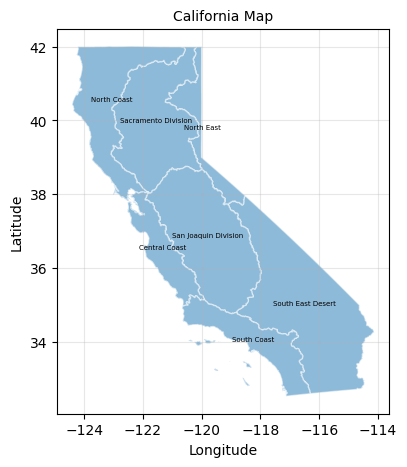

In [6]:
# Plot the locations of the California climate divisions. 
ax = ca_divisions.plot(figsize=(15,5), edgecolor="white", alpha=0.5)
ax.set_title("California Map", fontsize=10)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(alpha=0.3)
ca_divisions.apply(lambda row: ax.text(row["lon"], row["lat"], row.name,
                                       fontsize=5, ha='center', color='black'), axis=1)
plt.show();


## California Climate Division Weather Data

**California Weather Data:**
- Average temperature from 1895 to 2025 for all California divisons shown in the above map except for the North East Basin.
    - We will skip the North East basin because it is relatively very small in size.
- Data is in CSV format.
- Each division has a seperate CSV file for a weather variable. E.g. each division has one file for precipitation and one file for avg temperatue. So total 6 CSV files for the 6 divisions.
- Each CSV file has:

      - 131 rows: one for each year from 1895 to 2025
      - 13 columns: 12 columns for each month and a column for year.
- Temperatures are in tenths of deg. Fahrenheit.  ie.  -35 = -3.5 F,  557 = 55.7 F
- External link to the data: From https://calclim.dri.edu/pages/tools.html follow the US Divisional Climate Data (http://www.wrcc.dri.edu/spi/divplot2map.html) link.
- This is a publicly available data from Calclim which is a joint venture of the Western Regional Climate Center and the Scripps Institution of Oceanography. I do not see any ethical concerns in using this data.

In [8]:
# Seperate file for each division
# Therefore, total 6 files for 6 divisions
# Checkout a sample file 
pd.read_csv("../datasets/weather_CA_divisions_1895_2025/Central Coast/avg_temp_ccd - avg_temp_CCD.csv").head(3)

,Year,Jan.,Feb.,Mar.,Apr.,May,Jun.,Jul.,Aug.,Sep.,Oct.,Nov.,Dec.
0,1895,459,495,498,534,590,645,667,668,634,603,503,449
1,1896,490,500,516,490,561,648,673,672,624,604,494,495
2,1897,459,469,459,561,606,653,687,690,656,576,508,461


In [9]:

# Helper function to read and combine data for the user specified climate variable for all CA divisions
def combine_ca_division_weather_data(variable, title, ylabel, data_dir):
    all_divisions = pd.DataFrame()
    for subdir in os.listdir(data_dir):
        subdir_p = os.path.join(data_dir, subdir)
        if os.path.isdir(subdir_p):
            division = subdir
            #print("CA Division: ", division)
            for file_name in os.listdir(subdir_p):
                if variable in file_name and file_name.endswith('.csv'):
                    file_path = os.path.join(subdir_p, file_name)
                    df = pd.read_csv(file_path)
                    
                    # Transform the dataframe from a wide format to a long format
                    df.rename(columns={'Year': 'year'}, inplace=True)
                    df = pd.melt(df, id_vars=["year"], var_name="month", value_name=division)
                    df["month"] = df["month"].str.replace('.', '', regex=False)
                    df["date"] = pd.to_datetime(df["month"] + '-' + df["year"].astype(str), format='%b-%Y')
                    df = df.set_index("date").sort_index()
 
                    # Temperature in tenths of deg. Fahrenheit.  ie.  -35 = -3.5 F,  557 = 55.7 F
                    df[division] = df[division]/10
                
                    if all_divisions.empty:
                        all_divisions = df.copy()
                    else:
                        # Do not include year and month columns for subsequent divisions
                        all_divisions = pd.concat([all_divisions, df[[division]]], axis=1)
                        
    return all_divisions

In [10]:
# Read avg temp data for all 6 CA divisions and combine them into one dataframe
ca_avg_temps = combine_ca_division_weather_data("avg_temp", "Annual Average Temperature", "Temperature (F)",
                                                "../datasets/weather_CA_divisions_1895_2025/")

ca_avg_temps.head()

,year,month,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
date,,,,,,,,
1895-01-01,1895,Jan,43.6,45.7,37.9,45.9,37.4,39.7
1895-02-01,1895,Feb,50.4,50.0,43.0,49.5,43.5,44.6
1895-03-01,1895,Mar,53.8,49.9,43.6,49.8,45.1,45.8
1895-04-01,1895,Apr,61.0,53.8,48.3,53.4,51.1,51.8
1895-05-01,1895,May,70.7,61.4,53.5,59.0,57.6,59.7


In [11]:
ca_avg_temps.tail(2)

,year,month,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
date,,,,,,,,
2025-11-01,2025,Nov,999.9,999.9,999.9,999.9,999.9,999.9
2025-12-01,2025,Dec,999.9,999.9,999.9,999.9,999.9,999.9


In [12]:
ca_avg_temps.shape

(1572, 8)

### Data Cleanup

In [14]:
# Display rows that have missing data (values set to 999.9)
ca_avg_temps[(ca_avg_temps == 999.9).any(axis=1)]

,year,month,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
date,,,,,,,,
2025-02-01,2025,Feb,999.9,999.9,999.9,999.9,999.9,999.9
2025-03-01,2025,Mar,999.9,999.9,999.9,999.9,999.9,999.9
2025-04-01,2025,Apr,999.9,999.9,999.9,999.9,999.9,999.9
2025-05-01,2025,May,999.9,999.9,999.9,999.9,999.9,999.9
2025-06-01,2025,Jun,999.9,999.9,999.9,999.9,999.9,999.9
2025-07-01,2025,Jul,999.9,999.9,999.9,999.9,999.9,999.9
2025-08-01,2025,Aug,999.9,999.9,999.9,999.9,999.9,999.9
2025-09-01,2025,Sep,999.9,999.9,999.9,999.9,999.9,999.9
2025-10-01,2025,Oct,999.9,999.9,999.9,999.9,999.9,999.9


In [15]:
# Data for Feb to Dec 2025 is not available hence the values are set to 999.9 
# Remove all data for 2025
ca_avg_temps = ca_avg_temps[ca_avg_temps["year"] < 2025]
ca_avg_temps.tail(3)

,year,month,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
date,,,,,,,,
2024-10-01,2024,Oct,72.8,67.6,58.4,67.1,61.1,65.6
2024-11-01,2024,Nov,52.8,54.8,43.2,52.0,43.9,48.0
2024-12-01,2024,Dec,52.8,55.0,43.7,52.6,44.0,47.7


In [16]:
# Check for NaNs
ca_avg_temps.isna().sum()

year                    0
month                   0
South East Desert       0
South Coast             0
North Coast             0
Central Coast           0
Sacramento Division     0
San Joaquin Division    0
dtype: int64

In [17]:
ca_avg_temps.shape

(1560, 8)

In [18]:
# Check for gaps in the data

# Expected number of entries
start_year = int(ca_avg_temps["year"].min())
end_year = int(ca_avg_temps["year"].max())
expected_num_rows = (end_year - start_year + 1) * 12
if ca_avg_temps.shape[0] != expected_num_rows:
    print("Some years have gaps in data. Expected number of entries:{}, Actual:{}".format(expected_num_rows, ca_avg_temps.shape[0]))
else:
    print("No gaps in the data")

No gaps in the data


In [19]:
divs = [x for x in list(ca_avg_temps.columns) if x not in ["year", "month"]]

In [20]:
years_str = " (" + str(start_year) + "-" + str(end_year) + ")"
temp_ylabel = "Average Temperature (°F)"

In [21]:
# Get yearly average temps per division
ca_temp_by_year = ca_avg_temps.groupby("year")[divs].mean()
ca_temp_by_year.head(3)

,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
year,,,,,,
1895,63.191667,57.816667,51.083333,56.208333,53.608333,55.075000
1896,64.791667,59.075000,51.583333,56.391667,54.425000,55.975000
1897,63.000000,57.675000,51.191667,56.541667,53.541667,55.383333


In [22]:
# Helper function for linear regression
def linear_regression(x, y, show_eval_metrics=True):
    x2 = sm.add_constant(x)
    model_lr = sm.OLS(y,x2).fit()
    y_pred = model_lr.fittedvalues

    if show_eval_metrics:
        print("Linear regression model summary:\n", model_lr.summary())
        print("R^2: ", model_lr.rsquared)
        rmse_err = root_mean_squared_error(y, y_pred)
        print("RMSE: ",rmse_err)
    
    return y_pred

# Helper function to plot data
def plot_ca_div_data(data, title, ylabel, plot_linear_regression=False, col="avg_temp", figsize=(12,4)):
    if plot_linear_regression:
        # Draw linear regression line with time (year) as the predictor
        t = 1 + (data["year"] - data["year"][0])
        data_lr = np.squeeze(data[col])
        y_pred = linear_regression(t, data_lr, show_eval_metrics=False)
        plt.figure(figsize=figsize)
        plt.plot(data["year"], data_lr, label=col, linewidth=3)
        plt.plot(data["year"], y_pred, "r--", label="Linear Regression Trend Line", linewidth=2)
    else:
        data.plot(grid=True, figsize=figsize, fontsize=15)
    plt.xlabel("Year", fontsize=10)
    plt.ylabel(temp_ylabel, fontsize=10)
    plt.title(title, fontsize=15)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.grid(True)
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)
    plt.show();


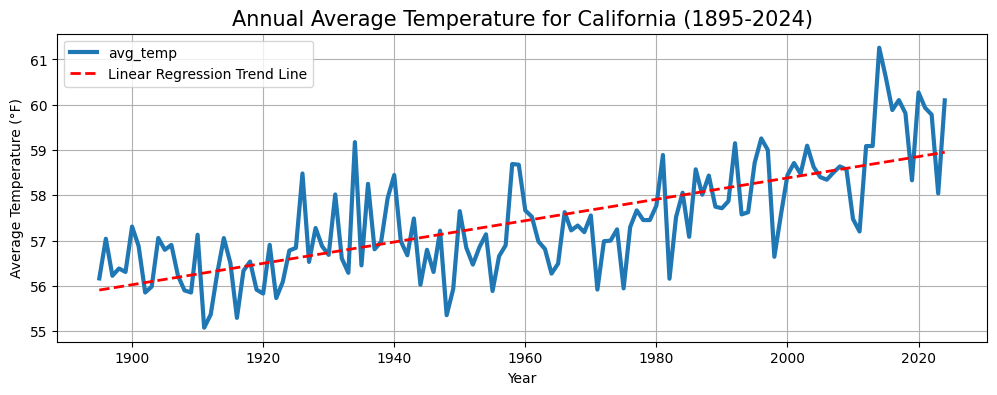

In [23]:
# Plot yearly avg temps for the state of California
plot_ca_div_data(ca_temp_by_year.mean(axis=1).reset_index(name='avg_temp'), 
                 "Annual Average Temperature for California" + years_str, "Temperature (F)",
                 plot_linear_regression=True)

<font color="purple"> <font size=3> The annual average temperature plot indicates a rising trend in California's average temperature over the years, as demonstrated by the linear regression trend line. <font>

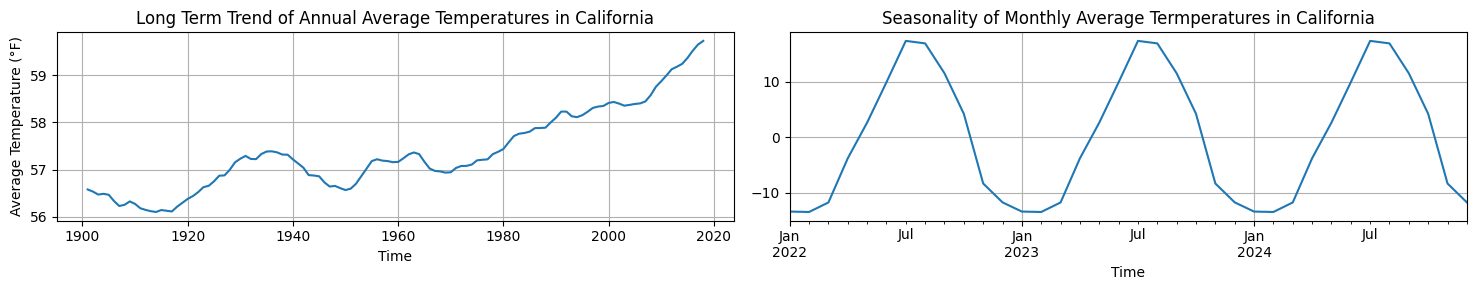

In [25]:
# Decompose and plot various characteristics of the temperature time series
fig, axes = plt.subplots(1,2, figsize=(15,3))
# Use annual averages to see the long term trend
decomp = seasonal_decompose(ca_temp_by_year.mean(axis=1), model='additive', period=12)
decomp.trend.plot(ax=axes[0], title="Long Term Trend of Annual Average Temperatures in California", grid=True, ylabel=temp_ylabel, xlabel="Time")

# Use monthly averages for last 3 years to see the seasonality
ca_temp_all_divs = ca_avg_temps[divs].mean(axis=1)
decomp = seasonal_decompose(ca_temp_all_divs[ca_temp_all_divs.index.year > (end_year - 3)], model='additive', period=12)
decomp.seasonal.plot(ax=axes[1], title="Seasonality of Monthly Average Termperatures in California", grid=True, xlabel="Time")

plt.tight_layout()
plt.show();

<font color="purple"> <font size=3> The plot shows a seasonal pattern in monthly average temperatures, as expected, along with a noticeable upward trend in California’s annual average temperatures, particularly since the 1970s.</font>

<font color="red"> <font size=3> Refer to the Jupyter notebook available [here](https://github.com/dpoonam/AI-ML-DataScience/blob/main/GeoScience/notebooks/California_Temperature_Spatial_Temporal_Analysis.ipynb) for additional exploratorty data analysis of this data.  </font>

## California Average Temperature Forecast

Use historical monthly average temperature data from 1895 to 2023 to forecast monthly average temperatures for the year 2024. Apply different forecasting techniques and evaluate their performance.

In [29]:
historical_temps = ca_avg_temps[ca_avg_temps["year"] < end_year]
# Actual temps will be used to evaluate the forecast
actual_temps = ca_avg_temps[ca_avg_temps["year"] == end_year][divs]

In [30]:
base_title = "California Average Temperature Forecast for the Year: " + str(end_year)
# Plot the forecast along with the actual values for comparison
def plot_forecast(forecast_data, title):
    print("================================ {} ================================".format(base_title))
    print("\n Forecast Method: " + title)
    # 6 panels (one fore each division) arranged in 2 x 3 plots
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))
    ax_row = 0
    ax_col = 0
    for div in divs:
        ax = axes[ax_row][ax_col]
        actual_temps[div].plot(ax=ax, label="actual", linewidth=1)
        forecast_data[div].plot(ax=ax, color="red", label="forecast", linewidth=1)
        ax.legend()
        ax.set_title("Forecast for " + div)
        if ax_col == 0:
            ax.set_ylabel(temp_ylabel)
        if ax_row == 1:
            ax.set_xlabel("Year")
        else:
            ax.set_xlabel("")
        ax.grid(alpha=0.5)
        ax_col = (ax_col + 1) % 3
        if ax_col == 0:
            ax_row += 1
    plt.tight_layout()
    plt.show();

### Naive Approach
Due to the seasonal nature of temperature, the average temperature in a given month tends to be similar both to the preceding month within the same year and to the same month in the previous year. Based on this pattern, a simple forecasting approach is to set the temperature for a given month as the weighted average of the previous month's observed temperature and the temperature observed in the same month of the prior year. For example, the forecast for February 2024 can be calculated as the weighted average of the observed temperature in January 2024 and February 2023.

We will experiement with different weights to determine which one results in the most accurate forecast. 

In [32]:
previous_year = historical_temps.shift(12, freq='MS')[-12:][divs]
previous_month = pd.concat([historical_temps[-1:][divs], actual_temps]).shift(1, freq='MS')

# Experiment with different weighted averages
for prev_year_weight in [0, 0.25, 0.5, 0.75, 1]:
    prev_month_weight = 1 - prev_year_weight
    forecast = (previous_year * prev_year_weight) + (previous_month * prev_month_weight)
    forecast.dropna(inplace=True)
    rmse = np.round(root_mean_squared_error(actual_temps, forecast), 2)
    r2 = np.round(r2_score(actual_temps, forecast), 2)
    print("Previous year weight: {}, Previous month weight: {}, \n   RMSE:{}, R\u00b2: {}".format(prev_year_weight, prev_month_weight, rmse, r2))

Previous year weight: 0, Previous month weight: 1, 
   RMSE:7.08, R²: 0.63
Previous year weight: 0.25, Previous month weight: 0.75, 
   RMSE:5.73, R²: 0.76
Previous year weight: 0.5, Previous month weight: 0.5, 
   RMSE:4.55, R²: 0.84
Previous year weight: 0.75, Previous month weight: 0.25, 
   RMSE:3.7, R²: 0.9
Previous year weight: 1, Previous month weight: 0, 
   RMSE:3.42, R²: 0.91


<font color="purple"> <font size=3> The root mean squared error (RMSE) decreases and $R^{2}$ increases as more weight is assigned to the previous year's values, with the lowest RMSE and highest $R^{2}$ occurring when the previous year is given full weight. This suggests that incorporating the previous month's temperature does not improve forecast accuracy. Among the naive approaches, the most effective is to directly use the values observed in the same month of the previous year. Detailed interpretation of RMSE and $R^{2}$ values is covered later in this notebook. </font>

================================ California Average Temperature Forecast for the Year: 2024 ================================

 Forecast Method: Set to previous year's monthly average temperatures


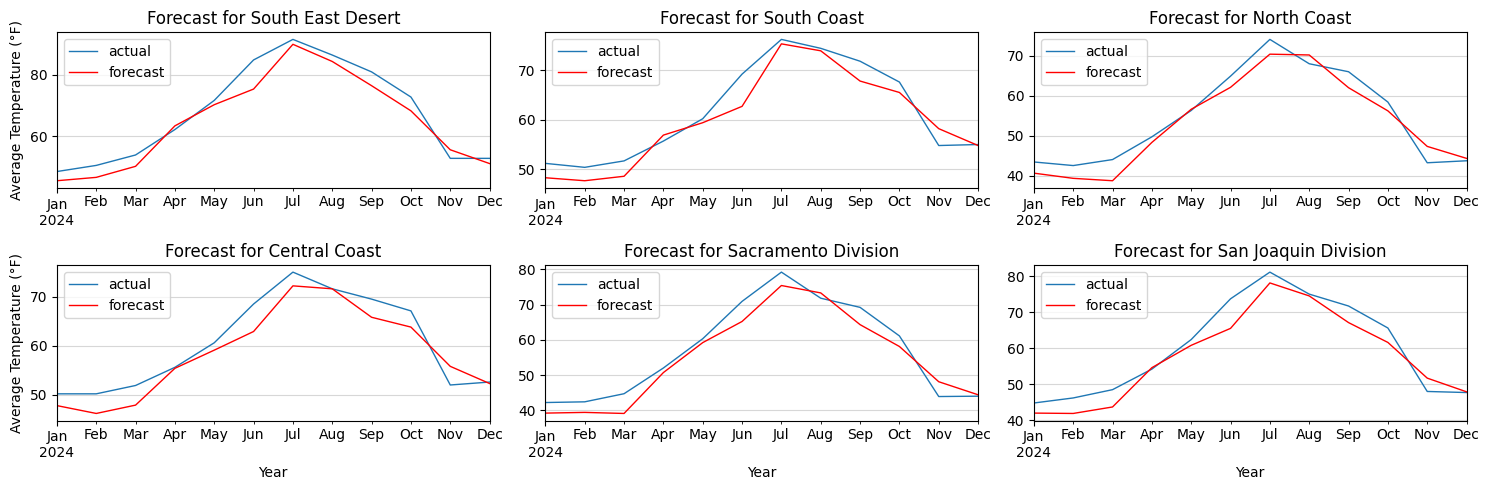

In [34]:
forecast = previous_year
plot_forecast(forecast, "Set to previous year's monthly average temperatures")

### Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) suitable for learning patterns in a sequence of data. As a result, it is well-suited for time series forecasting because it can remember important information from the past and for a long time. This makes it useful for predicting things like monthly temperatures, where past trends and seasonal patterns matter. 

In [36]:
# Helper function to create a list of sequences and labels
# seq_length is number of time steps to look back while making the prediction
# E.g. If seq_length is 12 then in our case the model will look back 12 months to forecast temperature for the 13th month.
# So in each sequence, X values are of length 12 and y (label) is the value immediately after the sequence.
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(np.array(xs), dtype=torch.float32), torch.tensor(np.array(ys), dtype=torch.float32)


In [37]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1, :])
        return out

In [38]:
# Train data is used to train the model
# validation data is to evaluate the model to prevent overfitting
def train(train_df, val_df, ax, seq_len=12, epochs=100, device="cpu"):
    # Scale and reshape to 2D array
    scaler = MinMaxScaler()
    train_df_scaled = scaler.fit_transform(train_df.reshape(-1, 1))
    val_df_scaled = scaler.fit_transform(val_df.reshape(-1, 1))

    X_train, y_train = create_sequences(train_df_scaled, seq_len)    
    #print("X_train shape:{}, y_train shape:{}".format(X_train.shape, y_train.shape))
    X_val, y_val = create_sequences(val_df_scaled, seq_len)    
    #print("X_val shape:{}, y_val shape:{}".format(X_val.shape, y_val.shape))

    input_size = 1
    # Number of hidden units
    hidden_size = 64
    num_layers = 2
    # Regularization
    dropout = 0.2
    # Learning rate
    alpha = 0.001
    
    model = LSTMModel(input_size, hidden_size, num_layers, dropout)
    loss_function = nn.MSELoss(reduction = "mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

    batch_size = 32
    train_dataset = TensorDataset(X_train, y_train)
    # We are shuffling the batches here and not the time series sequence within the batch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_loss = []
    val_loss = []
    best_val_loss = np.inf
    best_model = None
    num_epochs_executed = epochs
    # Execute atleast these many epochs before stopping
    min_epochs_early_stopping = 40

    # One epoch = one complete pass of the entire training data through the neural network
    for epoch in range(epochs):
        loss_total = 0.0
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_X)
            loss = loss_function(output, batch_y)
            loss.backward()
            optimizer.step()
            loss_total += loss.item()
        average_loss = loss_total / len(train_loader)
        train_loss.append(average_loss)

        model.eval()
        with torch.no_grad():
            v_loss_total = 0.0
            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
                output_val = model(batch_X_val)
                v_loss = loss_function(output_val, batch_y_val)
                v_loss_total += v_loss.item()
        average_val_loss = v_loss_total / len(val_loader)
        val_loss.append(average_val_loss)

        if (epoch + 1) % 10 == 0:
            print("Epoch [{}/{}] - Training Loss:{:.4f}, Validation Loss:{:.4f}".format(epoch + 1, epochs,
                                                                                        average_loss, average_val_loss))

        # Using a simple early stopping approach
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            best_model = model
            best_epoch = epoch
        else:
            if epoch > min_epochs_early_stopping:
                print("Early stopping triggered.")
                #print("Current validation loss {:.4f}, best validation loss {:.4f}.".format(average_val_loss, best_val_loss))
                num_epochs_executed = epoch + 1
                break

    x = np.linspace(1, num_epochs_executed, num_epochs_executed)
    ax.plot(x, train_loss, scalex=True, label="Training loss")
    ax.plot(x, val_loss, label="Validation loss")
    ax.legend()
    
    return best_model

In [39]:
# Split the dataset into train, validation and test set
num_years = ca_avg_temps["year"].max() - ca_avg_temps["year"].min()

# We will use the last year for testing the forecast
test_year = int(ca_avg_temps["year"].max())

# Of the remaining years, use 80% for training, 20% for validation
num_years -= 1
num_train_years = int(num_years * 0.8)
num_val_years = num_years - num_train_years
train_year_end = int(ca_avg_temps["year"].min()) + num_train_years
val_year_start = train_year_end + 1
val_year_end = val_year_start + num_val_years - 1
print("Trainding data from {} to {}".format(ca_avg_temps["year"].min(), train_year_end))
print("Validation data from {} to {}".format(val_year_start, val_year_end))
print("Test data from {}".format(test_year))

train_historical = ca_avg_temps[ca_avg_temps["year"] <= train_year_end][divs]
val_historical = ca_avg_temps[(ca_avg_temps["year"] >= val_year_start) & (ca_avg_temps["year"] <= val_year_end)][divs]
# To generate forecast for 2024, we also need data for 2023, hence test has data for last two years
test_historical = ca_avg_temps[ca_avg_temps["year"] >= (test_year - 1)][divs]

Trainding data from 1895 to 1997
Validation data from 1998 to 2023
Test data from 2024


In [40]:
# Generate monthly temperature forecast for the specified forecast window and evaluate it against observed values
def forecast_division(test_df, model, division, seq_len = 12, device="cpu"):
    scaler = MinMaxScaler()
    test_df_scaled = scaler.fit_transform(test_df.reshape(-1, 1))

    X_test, y_test = create_sequences(test_df_scaled, seq_len)    
    #print("X_test shape:{}, y_test shape:{}".format(X_test.shape, y_test.shape))
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    model.eval()
    forecast = []
    actuals = []
    with torch.no_grad():
        for input_ts, label in test_loader:
            input_ts, label = input_ts.to(device), label.to(device)
            outputs = model(input_ts).cpu().numpy()[0, 0]
            # Inverse transform the scaled predictions
            forecast.extend(scaler.inverse_transform(np.array(outputs).reshape(-1, 1)))
            # Inverse transform the scaled actual values
            actuals.extend(scaler.inverse_transform(np.array(label).reshape(-1, 1)))

        # Evaluate using RMSE, R2
        rmse = root_mean_squared_error(actuals, forecast)
        r2 = r2_score(actuals, forecast)
        print("{}: Forecast RMSE: {:.4f}, R\u00b2: {:.4f}".format(division, rmse, r2))

    return forecast, rmse, r2



Training for South East Desert...
Epoch [10/100] - Training Loss:0.0038, Validation Loss:0.0138
Epoch [20/100] - Training Loss:0.0035, Validation Loss:0.0099
Epoch [30/100] - Training Loss:0.0033, Validation Loss:0.0071
Epoch [40/100] - Training Loss:0.0032, Validation Loss:0.0078
Early stopping triggered.
South East Desert: Forecast RMSE: 3.8182, R²: 0.9368

Training for South Coast...
Epoch [10/100] - Training Loss:0.0055, Validation Loss:0.0118
Epoch [20/100] - Training Loss:0.0051, Validation Loss:0.0079
Epoch [30/100] - Training Loss:0.0047, Validation Loss:0.0072
Epoch [40/100] - Training Loss:0.0042, Validation Loss:0.0069
Early stopping triggered.
South Coast: Forecast RMSE: 2.8272, R²: 0.9071

Training for North Coast...
Epoch [10/100] - Training Loss:0.0048, Validation Loss:0.0207
Epoch [20/100] - Training Loss:0.0044, Validation Loss:0.0103
Epoch [30/100] - Training Loss:0.0041, Validation Loss:0.0106
Epoch [40/100] - Training Loss:0.0038, Validation Loss:0.0096
Early stopp

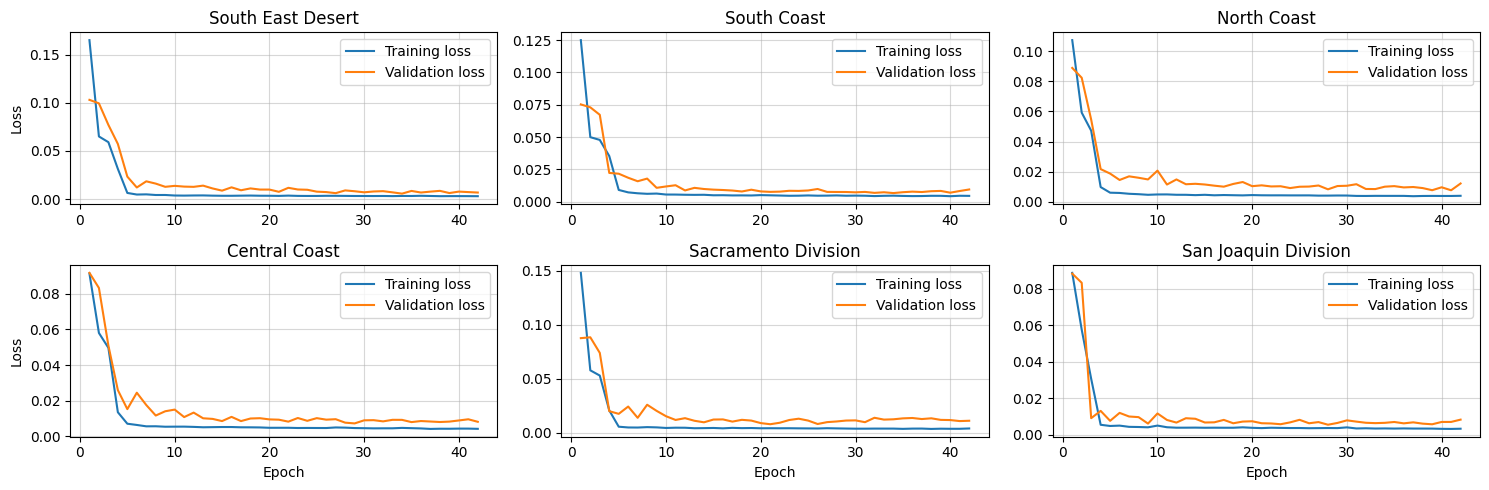

================================ California Average Temperature Forecast for the Year: 2024 ================================

 Forecast Method: LSTM Forecast


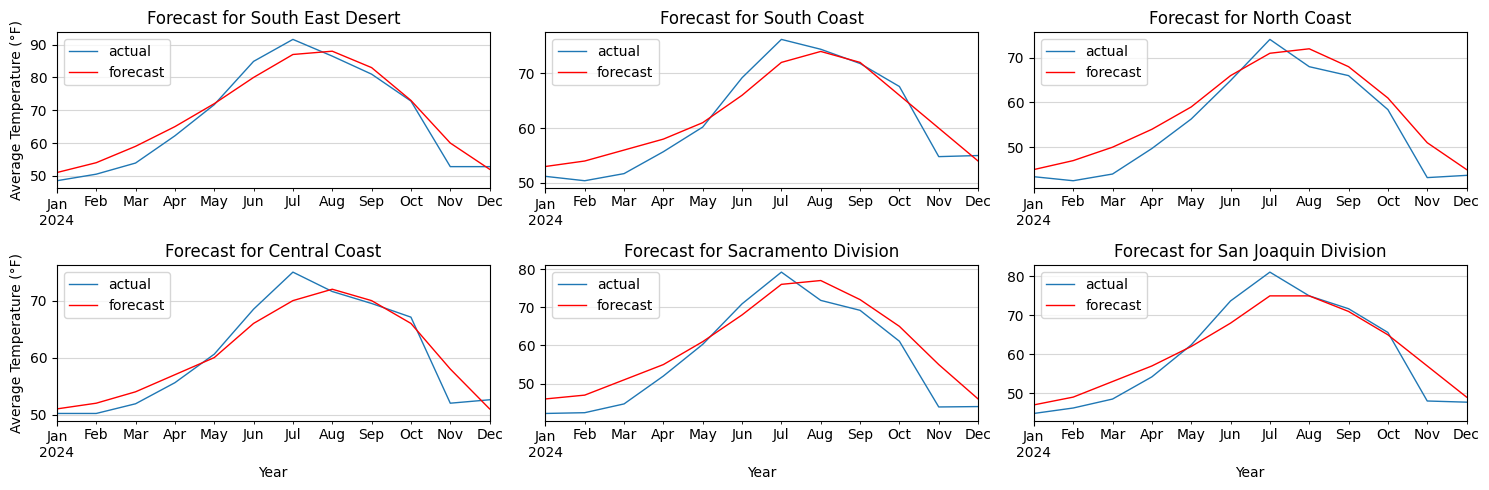

California (average across divisions): RMSE: 3.8302, R²: 0.8892


In [41]:
# Train the model and generate forecast for each division
forecast_results = {}
rmse_results = 0
r2_results = 0

# 6 panels, one per division, arranged as 2 x 3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15,5))
ax_row = 0
ax_col = 0
for div in divs:
    print("\nTraining for {}...".format(div))
    train_series = train_historical[div].values
    val_series = val_historical[div].values
    test_series = test_historical[div].values
    ax = axes[ax_row][ax_col]
    ax.legend()
    ax.set_title(div)
    if ax_col == 0:
        ax.set_ylabel("Loss")
    if ax_row == 1:
        ax.set_xlabel("Epoch")
    else:
        ax.set_xlabel("")
    ax.grid(alpha=0.5)
    ax_col = (ax_col + 1) % 3
    if ax_col == 0:
        ax_row += 1
    model = train(train_series, val_series, ax)

    if model:
        forecast, rmse, r2 = forecast_division(test_historical[div].values, model, div)
        forecast_results[div] = forecast
        rmse_results  += rmse
        r2_results += r2
    
plt.tight_layout()
plt.show();

# Plot forcast vs actual
if forecast_results:
    forecast_df = pd.DataFrame(forecast_results, index=actual_temps.index)
    forecast_df = forecast_df.astype(int)
    plot_forecast(forecast_df, "LSTM Forecast")
    print("California (average across divisions): RMSE: {:.4f}, R\u00b2: {:.4f}".format(rmse_results/len(divs), 
                                                                                                           r2_results/len(divs)))


In [42]:
# Temp range used for RMSE analysis
round(ca_avg_temps[divs].max().max() - ca_avg_temps[divs].min().min(), 2)

64.0

## Conclusions
<font size=4> Interpretation of the Forecast Evaluation Metrics Averaged across California Climate Divisions: </font>

| Evaluation Metric | Naive Approach (Set to previous year's monthly average temperatures) | LSTM|
|:--------:|:--------:|:--------:|
|  $R^{2}$ (Higher is better)  |  0.91 (i.e. 91% of the variataion in avg. temperature around its mean is explained by this model)  |  0.89 (i.e. 89% of the variataion in avg. temperature around its mean is explained by this model)  |
|  Root Mean Squared Erroor (RMSE) (Lower is better)  |  3.42 (i.e. avg. monthly temperature predicted by this model can be off by around 3.42 &deg;F on average)  |  3.83 (i.e. avg. monthly temperature predicted by this model can be off by 3.83 &deg;F on average)  |
 
<font size=4> Based on the analysis above, the naive approach (using the previous year's same-month values as the forecast) slightly outperforms the LSTM method. Both models have $R^{2}$ values around 90% and RMSEs around 3.4 - 3.8 &deg;F (which is roughly ~5.5% of the avg. temperature range of 64 &deg;F) </font>